# Visualizações e pré-processamento

Este notebook é utilizado tanto para visualização quanto pré-processamento dos dados de entrada.

### Imports e configurações iniciais

In [1]:
# If necessary
# %pip install wordcloud;

In [2]:
import nltk
from wordcloud import WordCloud
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from unidecode import unidecode
from sklearn.base import BaseEstimator, TransformerMixin
import boto3
nltk.download('all');

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     /home/ec2-user/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /home/ec2-user/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /home/ec2-user/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /home/ec2-user/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /home/ec2-user/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading pa

### Definições de funções úteis

In [3]:
def plot_cloud(words_string):
    """
    Função para plotar nuvem de palavras
    """
    nuvem_palavras = WordCloud(width= 1000, height= 800, max_font_size = 110, collocations= False).generate(words_string)
    plt.figure(figsize=(12,8))
    plt.imshow(nuvem_palavras, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    
def plot_word_counts(tokens, n=10):
    """
    Função para plotar gráfico com contagens das 'n' palavras mais comuns presentes nos 'tokens'
    """
    frequency = nltk.FreqDist(tokens)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                 "Frequency": list(frequency.values())})
    plt.figure(figsize=(16,8))
    ax = sns.barplot(data = df_frequency.sort_values(by=['Frequency'], ascending=False).head(n), x = "Word", y = "Frequency")
    ax.set(ylabel = "Count")
    plt.show()

### Visualizações com dados crus

In [4]:
bucket = 'projetointerdisciplinardadosbrutos'
file_name = 'dados_brutos.csv'
raw_data = pd.read_csv(f's3://{bucket}/{file_name}')
raw_data.head()

,fake,text
0,0,A divisão do STF ao meio entre partidários e ...
1,1,"General manda recado para STF: ""Abaixaram as c..."
2,1,O Nordeste acordou! Lula e o PT são enxotados:...
3,0,"Dois relatórios da Polícia Federal, com análi..."
4,1,Coreia do Norte declara status de QUASE-GUERRA...


In [5]:
raw_words =' '.join([text for text in raw_data.text])

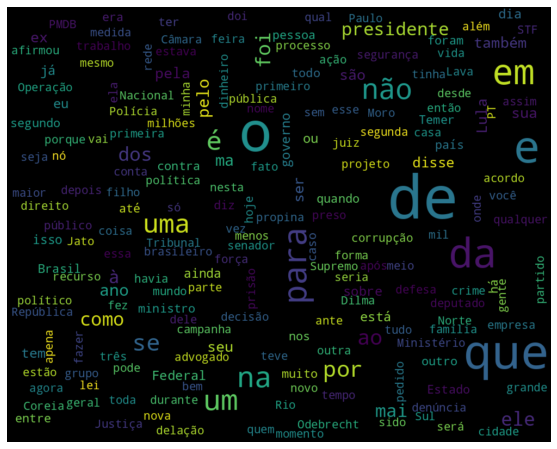

In [6]:
plot_cloud(raw_words)

Como é de se esperar, as contagens de palavras são dominadas por stopwords, palavras com pouco significado para os textos. 

### Visualização com dados processados

Para uma análise mais eficaz, é necessário eliminar as stopwords. Durante esta limpeza, também serão removidos sinais de pontuação, acentos e outros caracteres especiais e todas as palavras serão padronizadas para utilizar letras minúsculas apenas. Após esta limpeza, será feita uma nova visualização dos dados.

In [13]:
class StandarizeText(BaseEstimator, TransformerMixin):
    """
    Transformer para tokenizar a padronizar textos de entrada.
    Procedimentos realizados aqui incluem:
    - Converter texto só para minúsculas
    - Tokenizar (lista de palavras)
    - Remover pontuação (manter apenas palavras que passarem checagem isalpha())
    - Remover stopwords (manter apenas palavras que não estão na lista de stopwords do nltk)
    """
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_ = X.copy()
        ptbr_stopwords = nltk.corpus.stopwords.words('portuguese')
        ptbr_stopwords.append('r')
        X_ = X_.str.lower()
        X_ = X_.apply(lambda x: ' '.join([unidecode(word) for word in nltk.word_tokenize(x) 
                                         if word.isalpha() and word not in ptbr_stopwords]))
        return X_

In [14]:
processed_df = raw_data.copy()
processed_df['text'] =  StandarizeText().fit_transform(raw_data['text'])

In [15]:
processed_words = ' '.join([row for row in processed_df['text']])

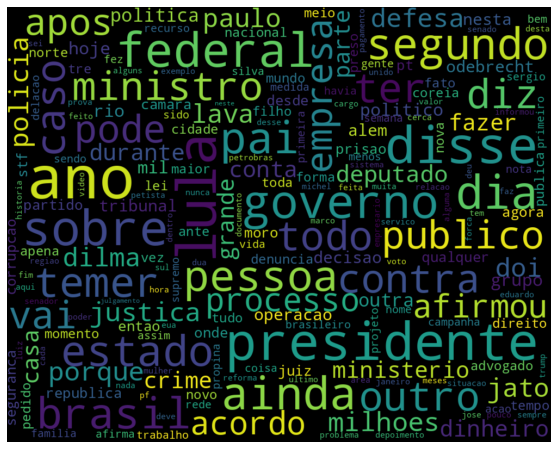

In [16]:
plot_cloud(processed_words)

In [17]:
token_phrases = nltk.word_tokenize(processed_words)

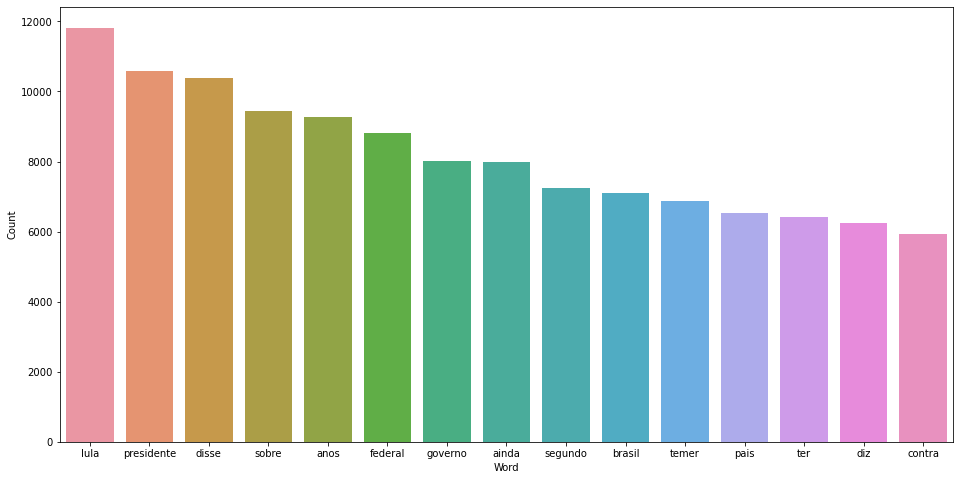

In [18]:
plot_word_counts(token_phrases, n=15)

Com o pré-processamento, nota-se que restam palavras mais significativas nos textos. Em particular, nota-se que os textos da base parecem enfatizar assuntos políticos.

Os dados pré-processados são então salvos para que possam ser utilizados no treinamento e validação de modelos.

In [21]:
processed_file = 'dados_processados.csv'
processed_bucket = 'projetointerdisciplinardadosprocessados'

processed_df.to_csv(processed_file, encoding='utf-8', index=False)
s3 = boto3.resource('s3')
with open(processed_file, 'rb') as f:
    s3.Bucket(processed_bucket).put_object(Key=processed_file, Body=f)